In [1]:
%run "..\..\Startup_py3.py"
sys.path.append(r"..\..\..\..\Documents")

import ImageAnalysis3 as ia
%matplotlib notebook

from ImageAnalysis3 import *
print(os.getpid())

import h5py
from ImageAnalysis3.classes import _allowed_kwds
import ast

19064


In [2]:
import cv2

In [3]:
data_folder = r'\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors'

folders, fovs = ia.io_tools.data.get_folders(data_folder)

dapi_image_file = os.path.join(data_folder, 'H0M1', 'Conv_zscan_001.dax')
#dapi_im = visual_tools.DaxReader(dapi_image_file).loadAll()[3::4][0::4]
#dapi_im = im[3::4]#[::4]

Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 12
- Number of field of views: 161


In [4]:
correction_folder = r'\\10.245.74.158\Chromatin_NAS_0\Corrections\20210621-Corrections_lumencor_from_60_to_50'

segmentation_save_folder = os.path.join(data_folder, 'Segmentation')
if not os.path.exists(segmentation_save_folder):
    os.makedirs(segmentation_save_folder)
from cellpose import models

from ImageAnalysis3.segmentation_tools.cell import Align_Segmentation
reload(ia.segmentation_tools.cell)

# transpose with microscope
microscope_file = r'\\mendel\pu_documents\Merfish_analysis\Merfish_Analysis_Scripts\merlin_parameters\microscope\storm6_microscope.json'
microscope_params = Align_Segmentation._read_microscope_json(microscope_file)
microscope_params

{'flip_horizontal': False,
 'flip_vertical': True,
 'transpose': True,
 'microns_per_pixel': 0.108}

In [5]:
for _fov_id, _fov_name in enumerate(fovs):
    
    seg_save_file = os.path.join(segmentation_save_folder, f'segmentation_label_{_fov_id}.npy')
    if os.path.exists(seg_save_file):
        continue

    dapi_image_file = os.path.join(folders[0], _fov_name)
    polyt_image_file = os.path.join(folders[-1], _fov_name)
    print(dapi_image_file, polyt_image_file)
    # load reference DAPI
    _ref_cls = ia.classes.preprocess.DaxProcesser(dapi_image_file, 
                                                 CorrectionFolder=correction_folder, DriftChannel=488, DapiChannel=405)
    _ref_cls._load_image(sel_channels=[750,488,405])
    _ref_cls._corr_illumination()
    _ref_im = _ref_cls.im_488[0::4]
    # load polyT
    _cls = ia.classes.preprocess.DaxProcesser(polyt_image_file, 
                                              CorrectionFolder=correction_folder, DriftChannel=488, DapiChannel=405)
    _cls._load_image(sel_channels=[750,488])
    _cls._corr_illumination()
    _cls._calculate_drift(_ref_im)
    _cls._warp_image(corr_chromatic=False)
    # cellpose
    print(f"- apply microscope corrections")
    test_dapi_im = Align_Segmentation._correct_image3D_by_microscope_param(_ref_cls.im_405[0::4], microscope_params)
    test_polyt_im = Align_Segmentation._correct_image3D_by_microscope_param(_cls.im_750, microscope_params)
    
    print(f"- run Cellpose segmentation", end=' ')
    _cellpose_start = time.time()
    test_dapi_im = np.array([cv2.resize(_ly, (1024,1024) ) for _ly in test_dapi_im])
    test_polyt_im = np.array([cv2.resize(_ly, (1024,1024) ) for _ly in test_polyt_im])

    seg_model = models.CellposeModel(gpu=True, model_type='TN2')

    labels3d, _, _ = seg_model.eval(np.stack([test_polyt_im, test_dapi_im], axis=3), 
                                    batch_size=20, anisotropy=1000/108/2,
                                    cellprob_threshold=0, 
                                    channels=[1,2], diameter=30, min_size=100,
                                    do_3D=True,
                                    )

    print(f"in {time.time()-_cellpose_start:.3f}s.")
    
    
    # resize segmentation label back
    labels3d = np.array([cv2.resize(_ly, _cls.im_750.shape[1:], 
                                    interpolation=cv2.INTER_NEAREST_EXACT) 
                         for _ly in labels3d])

    
    print(labels3d.shape, _fov_id)
    # save this segmentation mask
    print(f"- save to file: {seg_save_file}")
    np.save(seg_save_file.split('.npy')[0], labels3d, )
    

## Check result

<IPython.core.display.Javascript object>


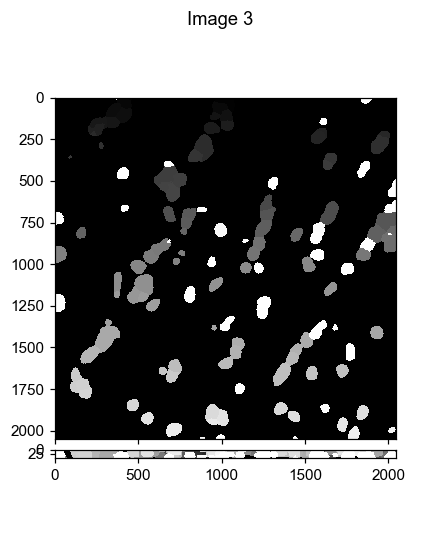

In [9]:
visual_tools.imshow_mark_3d_v2([_ref_cls.im_405, _cls.im_750, labels3d])

## Watershed

In [8]:
print(segmentation_save_folder)

\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\Segmentation


In [10]:
sys.path.append(r"..\..\MERlin")

import merlin
from merlin.util import watershed
from scipy import ndimage
from skimage import morphology
from skimage import segmentation

watershed_folder = os.path.join(segmentation_save_folder, 'watershed')
if not os.path.exists(watershed_folder):
    print(watershed_folder)
    os.makedirs(watershed_folder)

In [13]:
for _fov_id, _fov_name in enumerate(fovs):
    
    _save_id = _fov_id
    seg_save_file = os.path.join(segmentation_save_folder, f'segmentation_label_{_save_id}.npy')
    watershed_save_file = os.path.join(watershed_folder, f'segmentation_label_{_save_id}.npy')
    if os.path.exists(watershed_save_file):
        continue
    
    print(f"- load seg file: {seg_save_file}")
    corr_labels3d = np.load(seg_save_file).astype(np.int16)
    # load DAPI/polyT
    dapi_image_file = os.path.join(folders[0], _fov_name)
    polyt_image_file = os.path.join(folders[-1], _fov_name)
    print(dapi_image_file, polyt_image_file)
    # load reference DAPI
    _ref_cls = ia.classes.preprocess.DaxProcesser(dapi_image_file, 
                                                 CorrectionFolder=correction_folder, DriftChannel=488, DapiChannel=405)
    _ref_cls._load_image(sel_channels=[488,405])
    _ref_cls._corr_illumination()
    _ref_im = _ref_cls.im_488[0::4]
    # load polyT
    _cls = ia.classes.preprocess.DaxProcesser(polyt_image_file, 
                                              CorrectionFolder=correction_folder, DriftChannel=488, DapiChannel=405)
    _cls._load_image(sel_channels=[750,488])
    _cls._corr_illumination()
    _cls._calculate_drift(_ref_im)
    _cls._warp_image(corr_chromatic=False)
    polyt_im = Align_Segmentation._correct_image3D_by_microscope_param(_cls.im_750, microscope_params)
    # Prepare watershed
    waterIm, waterMask = watershed.prepare_watershed_images(polyt_im, 1.5)
    waterMask[corr_labels3d > 0] = True
    waterMask = ndimage.binary_dilation(waterMask, structure=morphology.ball(1))
    # watershed
    new_labels = segmentation.watershed(
                    waterIm, corr_labels3d, mask=waterMask,
                    connectivity=np.ones((3, 3, 3)), watershed_line=True)
    # save this segmentation mask
    print(f"- save to file: {watershed_save_file}")
    np.save(watershed_save_file.split('.npy')[0], new_labels, )


- load seg file: \\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\Segmentation\segmentation_label_1.npy
\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_001.dax \\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H11M12\Conv_zscan_001.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_001.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['488', '405'] in 3.969s.
- Start illumination correction for channels:['488', '405'].
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 488 in 8.199s.
-- corrected illumination for channel 405 in 8.485s.
- Finished illumination correction in 16.826s.
Initialize DaxProcesser for file:\\10.245.74.158\

- Loaded images for channels:['750', '488'] in 1.797s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 2.000s.
-- corrected illumination for channel 488 in 2.031s.
- Finished illumination correction in 4.313s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [-0.05 -9.91  4.89] in 0.812s.
-- drift 1: [-0.06 -9.92  5.16] in 0.828s.
-- drift 2: [-0.06 -9.82  5.01] in 0.828s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[-0.05666667 -9.88333333  5.02      ] for channel: 750
-- finish warpping channel 750 in 22.422s.
488 False True
-- warp image with drift:[-0.05666667 -9.88333333  5.02      ] for channel: 488
-- fi

- load seg file: \\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\Segmentation\segmentation_label_8.npy
\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_008.dax \\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H11M12\Conv_zscan_008.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_008.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['488', '405'] in 4.922s.
- Start illumination correction for channels:['488', '405'].
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 488 in 8.038s.
-- corrected illumination for channel 405 in 8.087s.
- Finished illumination correction in 16.344s.
Initialize DaxProcesser for file:\\10.245.74.158\

- Loaded images for channels:['750', '488'] in 1.171s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 2.078s.
-- corrected illumination for channel 488 in 2.141s.
- Finished illumination correction in 4.406s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [-0.03 -7.7   2.09] in 0.844s.
-- drift 1: [-0.02 -7.57  2.18] in 0.844s.
-- drift 2: [-0.04 -7.64  2.12] in 0.859s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[-0.03       -7.63666667  2.13      ] for channel: 750
-- finish warpping channel 750 in 23.047s.
488 False True
-- warp image with drift:[-0.03       -7.63666667  2.13      ] for channel: 488
-- fi

- save to file: \\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\Segmentation\watershed\segmentation_label_14.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\Segmentation\segmentation_label_15.npy
\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_015.dax \\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H11M12\Conv_zscan_015.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_015.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['488', '405'] in 5.437s.
- Start illumination correction for channels:['488', '405'].
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 488 in 8.487s.
-- corrected 

-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 2.359s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 2.187s.
-- corrected illumination for channel 488 in 2.156s.
- Finished illumination correction in 4.969s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [-0.04 -9.58  0.76] in 0.923s.
-- drift 1: [-0.04 -9.65  0.65] in 0.905s.
-- drift 2: [-0.09 -9.74  1.  ] in 0.907s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[-0.05666667 -9.65666667  0.80333333] for channel: 750
-- finish warpping channel 750 in 24.000s.
488 False True
--

- save to file: \\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\Segmentation\watershed\segmentation_label_21.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\Segmentation\segmentation_label_22.npy
\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_022.dax \\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H11M12\Conv_zscan_022.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_022.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['488', '405'] in 4.734s.
- Start illumination correction for channels:['488', '405'].
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 488 in 8.750s.
-- corrected 

- Loaded images for channels:['750', '488'] in 0.984s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 2.125s.
-- corrected illumination for channel 488 in 2.141s.
- Finished illumination correction in 4.438s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [-0.04 -9.93  2.14] in 0.797s.
-- drift 1: [-0.02 -9.45  2.12] in 0.828s.
-- drift 2: [-0.03 -9.47  2.07] in 0.875s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[-0.03       -9.61666667  2.11      ] for channel: 750
-- finish warpping channel 750 in 23.516s.
488 False True
-- warp image with drift:[-0.03       -9.61666667  2.11      ] for channel: 488
-- fi

- save to file: \\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\Segmentation\watershed\segmentation_label_28.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\Segmentation\segmentation_label_29.npy
\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_029.dax \\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H11M12\Conv_zscan_029.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_029.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['488', '405'] in 5.140s.
- Start illumination correction for channels:['488', '405'].
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 488 in 9.095s.
-- corrected 

-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 0.937s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 2.088s.
-- corrected illumination for channel 488 in 2.269s.
- Finished illumination correction in 4.566s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [ -0.07 -11.43  -0.51] in 0.869s.
-- drift 1: [ -0.03 -11.03  -0.43] in 0.836s.
-- drift 2: [ -0.06 -10.81  -0.39] in 0.825s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[ -0.05333333 -11.09        -0.44333333] for channel: 750
-- finish warpping channel 750 in 23.109s.
488 False True
-- warp image with drift:[ -0.0533

- save to file: \\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\Segmentation\watershed\segmentation_label_35.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\Segmentation\segmentation_label_36.npy
\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_036.dax \\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H11M12\Conv_zscan_036.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_036.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['488', '405'] in 6.031s.
- Start illumination correction for channels:['488', '405'].
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 488 in 8.250s.
-- corrected 

- Loaded images for channels:['750', '488'] in 1.688s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 2.061s.
-- corrected illumination for channel 488 in 2.109s.
- Finished illumination correction in 4.750s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [ -0.09 -11.02   1.22] in 0.828s.
-- drift 1: [ -0.15 -10.82   1.67] in 0.859s.
-- drift 2: [ -0.12 -10.85   1.52] in 0.859s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[ -0.12       -10.89666667   1.47      ] for channel: 750
-- finish warpping channel 750 in 23.109s.
488 False True
-- warp image with drift:[ -0.12       -10.89666667   1.47      ] for cha

-- warp image with drift:[ 3.33333333e-03 -8.99333333e+00  7.84666667e+00] for channel: 488
-- finish warpping channel 488 in 23.422s.
-- finish warpping in 47.344s.
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\Segmentation\watershed\segmentation_label_42.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\Segmentation\segmentation_label_43.npy
\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_043.dax \\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H11M12\Conv_zscan_043.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_043.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['488', '405'] in 9.531s.
- Start illumination correction for channels:['488', '405'].
-- loading illumination correction profile from fi

	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 488 in 9.903s.
-- corrected illumination for channel 405 in 8.545s.
- Finished illumination correction in 18.910s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H11M12\Conv_zscan_046.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 2.099s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 2.210s.
-- corrected illumination for channel 488 in 2.240s.
- Finished illumination correction in 4.941s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [-0.11 -8.85  8.64] in 0.907s.
-- drift 1: [-0.1  -8

-- drift 0: [-0.01 -8.72  1.44] in 0.844s.
-- drift 1: [-0.02 -8.66  1.48] in 0.844s.
-- drift 2: [-0.02 -8.69  1.58] in 0.844s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[-0.01666667 -8.69        1.5       ] for channel: 750
-- finish warpping channel 750 in 22.968s.
488 False True
-- warp image with drift:[-0.01666667 -8.69        1.5       ] for channel: 488
-- finish warpping channel 488 in 23.250s.
-- finish warpping in 46.218s.
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\Segmentation\watershed\segmentation_label_49.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\Segmentation\segmentation_label_50.npy
\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_050.dax \\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H11M12\Conv_zscan_050.dax
Ini

- Loaded images for channels:['488', '405'] in 4.766s.
- Start illumination correction for channels:['488', '405'].
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 488 in 8.281s.
-- corrected illumination for channel 405 in 8.172s.
- Finished illumination correction in 16.625s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H11M12\Conv_zscan_053.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 1.922s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 2.109s.
-- corrected illumination for channel 488 in 2.173

-- drift 0: [-0.12 -9.81 13.39] in 0.859s.
-- drift 1: [-0.12 -9.56 13.54] in 0.875s.
-- drift 2: [-0.16 -9.47 13.59] in 0.828s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[-0.13333333 -9.61333333 13.50666667] for channel: 750
-- finish warpping channel 750 in 22.859s.
488 False True
-- warp image with drift:[-0.13333333 -9.61333333 13.50666667] for channel: 488
-- finish warpping channel 488 in 23.172s.
-- finish warpping in 46.031s.
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\Segmentation\watershed\segmentation_label_56.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\Segmentation\segmentation_label_57.npy
\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_057.dax \\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H11M12\Conv_zscan_057.dax
Ini

- Loaded images for channels:['488', '405'] in 5.594s.
- Start illumination correction for channels:['488', '405'].
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 488 in 9.703s.
-- corrected illumination for channel 405 in 8.687s.
- Finished illumination correction in 18.547s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H11M12\Conv_zscan_060.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 1.703s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 2.172s.
-- corrected illumination for channel 488 in 2.156

-- drift 0: [-0.03 -8.59 11.29] in 0.859s.
-- drift 1: [-0.06 -8.46 11.42] in 0.865s.
-- drift 2: [-0.04 -8.27 11.24] in 0.838s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[-0.04333333 -8.44       11.31666667] for channel: 750
-- finish warpping channel 750 in 22.938s.
488 False True
-- warp image with drift:[-0.04333333 -8.44       11.31666667] for channel: 488
-- finish warpping channel 488 in 23.891s.
-- finish warpping in 46.828s.
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\Segmentation\watershed\segmentation_label_63.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\Segmentation\segmentation_label_64.npy
\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_064.dax \\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H11M12\Conv_zscan_064.dax
Ini

- Loaded images for channels:['488', '405'] in 4.391s.
- Start illumination correction for channels:['488', '405'].
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 488 in 8.266s.
-- corrected illumination for channel 405 in 8.375s.
- Finished illumination correction in 16.875s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H11M12\Conv_zscan_067.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 1.172s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 2.067s.
-- corrected illumination for channel 488 in 2.125

-- drift 0: [-0.01 -8.6   1.5 ] in 0.938s.
-- drift 1: [-0.01 -8.37  1.72] in 1.015s.
-- drift 2: [-0.03 -8.42  1.48] in 0.985s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[-0.01666667 -8.46333333  1.56666667] for channel: 750
-- finish warpping channel 750 in 23.859s.
488 False True
-- warp image with drift:[-0.01666667 -8.46333333  1.56666667] for channel: 488
-- finish warpping channel 488 in 23.422s.
-- finish warpping in 47.281s.
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\Segmentation\watershed\segmentation_label_70.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\Segmentation\segmentation_label_71.npy
\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_071.dax \\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H11M12\Conv_zscan_071.dax
Ini

- Loaded images for channels:['488', '405'] in 5.797s.
- Start illumination correction for channels:['488', '405'].
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 488 in 8.468s.
-- corrected illumination for channel 405 in 8.250s.
- Finished illumination correction in 16.938s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H11M12\Conv_zscan_074.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 0.812s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 2.140s.
-- corrected illumination for channel 488 in 2.157

-- drift 0: [-0.02 -6.66  5.66] in 0.843s.
-- drift 1: [-0.01 -6.57  5.79] in 0.859s.
-- drift 2: [-0.05 -6.5   5.65] in 0.828s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[-0.02666667 -6.57666667  5.7       ] for channel: 750
-- finish warpping channel 750 in 22.828s.
488 False True
-- warp image with drift:[-0.02666667 -6.57666667  5.7       ] for channel: 488
-- finish warpping channel 488 in 23.363s.
-- finish warpping in 46.192s.
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\Segmentation\watershed\segmentation_label_77.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\Segmentation\segmentation_label_78.npy
\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_078.dax \\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H11M12\Conv_zscan_078.dax
Ini

- Loaded images for channels:['488', '405'] in 5.719s.
- Start illumination correction for channels:['488', '405'].
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 488 in 8.281s.
-- corrected illumination for channel 405 in 8.219s.
- Finished illumination correction in 16.797s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H11M12\Conv_zscan_081.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 0.781s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 2.078s.
-- corrected illumination for channel 488 in 2.094

-- drift 0: [ -0.03 -10.65   5.96] in 0.843s.
-- drift 1: [ -0.02 -10.5    6.07] in 0.859s.
-- drift 2: [ -0.03 -10.43   5.91] in 0.875s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[ -0.02666667 -10.52666667   5.98      ] for channel: 750
-- finish warpping channel 750 in 23.015s.
488 False True
-- warp image with drift:[ -0.02666667 -10.52666667   5.98      ] for channel: 488
-- finish warpping channel 488 in 23.219s.
-- finish warpping in 46.234s.
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\Segmentation\watershed\segmentation_label_84.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\Segmentation\segmentation_label_85.npy
\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_085.dax \\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H11M12\Conv_zs

- Loaded images for channels:['488', '405'] in 5.474s.
- Start illumination correction for channels:['488', '405'].
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 488 in 8.566s.
-- corrected illumination for channel 405 in 9.313s.
- Finished illumination correction in 18.250s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H11M12\Conv_zscan_088.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 1.516s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 2.500s.
-- corrected illumination for channel 488 in 2.219

-- drift 0: [-0.13 -8.77  7.75] in 0.844s.
-- drift 1: [-0.16 -8.37  8.08] in 0.860s.
-- drift 2: [-0.17 -8.57  7.78] in 0.859s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[-0.15333333 -8.57        7.87      ] for channel: 750
-- finish warpping channel 750 in 23.000s.
488 False True
-- warp image with drift:[-0.15333333 -8.57        7.87      ] for channel: 488
-- finish warpping channel 488 in 23.250s.
-- finish warpping in 46.250s.
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\Segmentation\watershed\segmentation_label_91.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\Segmentation\segmentation_label_92.npy
\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_092.dax \\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H11M12\Conv_zscan_092.dax
Ini

- Loaded images for channels:['488', '405'] in 4.203s.
- Start illumination correction for channels:['488', '405'].
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 488 in 8.172s.
-- corrected illumination for channel 405 in 8.297s.
- Finished illumination correction in 16.625s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H11M12\Conv_zscan_095.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 1.078s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 2.209s.
-- corrected illumination for channel 488 in 2.078

-- drift 0: [-0.08 -4.89  1.16] in 0.878s.
-- drift 1: [-0.08 -4.92  1.08] in 0.840s.
-- drift 2: [-0.07 -4.81  1.14] in 0.828s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[-0.07666667 -4.87333333  1.12666667] for channel: 750
-- finish warpping channel 750 in 22.953s.
488 False True
-- warp image with drift:[-0.07666667 -4.87333333  1.12666667] for channel: 488
-- finish warpping channel 488 in 23.266s.
-- finish warpping in 46.219s.
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\Segmentation\watershed\segmentation_label_98.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\Segmentation\segmentation_label_99.npy
\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_099.dax \\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H11M12\Conv_zscan_099.dax
Ini

- Loaded images for channels:['488', '405'] in 5.875s.
- Start illumination correction for channels:['488', '405'].
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 488 in 8.461s.
-- corrected illumination for channel 405 in 9.453s.
- Finished illumination correction in 18.121s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H11M12\Conv_zscan_102.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 1.844s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 2.328s.
-- corrected illumination for channel 488 in 2.555

-- drift 0: [-0.02 -7.57 11.33] in 0.859s.
-- drift 1: [-0.02 -7.36 11.42] in 0.844s.
-- drift 2: [-1.000e-02 -7.410e+00  1.139e+01] in 0.844s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[-0.01666667 -7.44666667 11.38      ] for channel: 750
-- finish warpping channel 750 in 22.859s.
488 False True
-- warp image with drift:[-0.01666667 -7.44666667 11.38      ] for channel: 488
-- finish warpping channel 488 in 23.828s.
-- finish warpping in 46.688s.
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\Segmentation\watershed\segmentation_label_105.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\Segmentation\segmentation_label_106.npy
\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_106.dax \\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H11M12\Conv_

-- single image size: [  50 2048 2048]
- Loaded images for channels:['488', '405'] in 8.859s.
- Start illumination correction for channels:['488', '405'].
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 488 in 10.672s.
-- corrected illumination for channel 405 in 10.781s.
- Finished illumination correction in 21.563s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H11M12\Conv_zscan_109.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 1.187s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 2.343s.
-- correc

-- drift 0: [-0.05 -7.49  6.11] in 0.844s.
-- drift 1: [-0.04 -7.37  6.29] in 0.828s.
-- drift 2: [-0.05 -7.38  6.14] in 0.828s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[-0.04666667 -7.41333333  6.18      ] for channel: 750
-- finish warpping channel 750 in 23.047s.
488 False True
-- warp image with drift:[-0.04666667 -7.41333333  6.18      ] for channel: 488
-- finish warpping channel 488 in 23.406s.
-- finish warpping in 46.453s.
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\Segmentation\watershed\segmentation_label_112.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\Segmentation\segmentation_label_113.npy
\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_113.dax \\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H11M12\Conv_zscan_113.dax
I

- Loaded images for channels:['488', '405'] in 5.359s.
- Start illumination correction for channels:['488', '405'].
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 488 in 8.062s.
-- corrected illumination for channel 405 in 8.047s.
- Finished illumination correction in 16.297s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H11M12\Conv_zscan_116.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 0.906s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 2.171s.
-- corrected illumination for channel 488 in 2.079

-- drift 0: [-0.12 -6.29  8.27] in 0.906s.
-- drift 1: [-0.09 -6.12  8.39] in 0.859s.
-- drift 2: [-0.13 -6.08  8.23] in 0.891s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[-0.11333333 -6.16333333  8.29666667] for channel: 750
-- finish warpping channel 750 in 22.406s.
488 False True
-- warp image with drift:[-0.11333333 -6.16333333  8.29666667] for channel: 488
-- finish warpping channel 488 in 22.531s.
-- finish warpping in 44.937s.
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\Segmentation\watershed\segmentation_label_119.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\Segmentation\segmentation_label_120.npy
\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_120.dax \\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H11M12\Conv_zscan_120.dax
I

- Loaded images for channels:['488', '405'] in 6.063s.
- Start illumination correction for channels:['488', '405'].
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 488 in 8.109s.
-- corrected illumination for channel 405 in 9.000s.
- Finished illumination correction in 17.266s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H11M12\Conv_zscan_123.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 1.297s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 2.453s.
-- corrected illumination for channel 488 in 2.562

-- drift 0: [-0.08 -4.62  3.42] in 0.844s.
-- drift 1: [-0.07 -4.26  3.11] in 0.844s.
-- drift 2: [-0.09 -4.25  2.91] in 0.828s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[-0.08       -4.37666667  3.14666667] for channel: 750
-- finish warpping channel 750 in 22.313s.
488 False True
-- warp image with drift:[-0.08       -4.37666667  3.14666667] for channel: 488
-- finish warpping channel 488 in 22.438s.
-- finish warpping in 44.750s.
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\Segmentation\watershed\segmentation_label_126.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\Segmentation\segmentation_label_127.npy
\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_127.dax \\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H11M12\Conv_zscan_127.dax
I

- Loaded images for channels:['488', '405'] in 5.567s.
- Start illumination correction for channels:['488', '405'].
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 488 in 8.382s.
-- corrected illumination for channel 405 in 8.813s.
- Finished illumination correction in 17.391s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H11M12\Conv_zscan_130.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 0.922s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 2.441s.
-- corrected illumination for channel 488 in 2.172

-- drift 0: [-0.15 -6.62  5.47] in 0.828s.
-- drift 1: [-0.11 -6.66  5.62] in 0.828s.
-- drift 2: [-0.16 -6.52  5.68] in 0.828s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[-0.14 -6.6   5.59] for channel: 750
-- finish warpping channel 750 in 22.062s.
488 False True
-- warp image with drift:[-0.14 -6.6   5.59] for channel: 488
-- finish warpping channel 488 in 22.547s.
-- finish warpping in 44.609s.
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\Segmentation\watershed\segmentation_label_133.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\Segmentation\segmentation_label_134.npy
\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_134.dax \\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H11M12\Conv_zscan_134.dax
Initialize DaxProcesser for file:\\10

- Loaded images for channels:['488', '405'] in 6.938s.
- Start illumination correction for channels:['488', '405'].
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 488 in 7.953s.
-- corrected illumination for channel 405 in 8.031s.
- Finished illumination correction in 16.234s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H11M12\Conv_zscan_137.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 0.953s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 2.094s.
-- corrected illumination for channel 488 in 2.094

-- drift 0: [-0.08 -6.5   9.2 ] in 0.812s.
-- drift 1: [-0.06 -6.39  9.22] in 0.828s.
-- drift 2: [-0.08 -6.46  9.12] in 0.812s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[-0.07333333 -6.45        9.18      ] for channel: 750
-- finish warpping channel 750 in 22.203s.
488 False True
-- warp image with drift:[-0.07333333 -6.45        9.18      ] for channel: 488
-- finish warpping channel 488 in 22.500s.
-- finish warpping in 44.703s.
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\Segmentation\watershed\segmentation_label_140.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\Segmentation\segmentation_label_141.npy
\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_141.dax \\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H11M12\Conv_zscan_141.dax
I

- Loaded images for channels:['488', '405'] in 4.453s.
- Start illumination correction for channels:['488', '405'].
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 488 in 8.031s.
-- corrected illumination for channel 405 in 8.297s.
- Finished illumination correction in 16.547s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H11M12\Conv_zscan_144.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 0.984s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 2.078s.
-- corrected illumination for channel 488 in 2.015

-- drift 0: [-0.07 -6.76  8.35] in 0.891s.
-- drift 1: [-0.06 -6.75  8.44] in 0.844s.
-- drift 2: [-0.06 -6.69  8.28] in 0.844s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[-0.06333333 -6.73333333  8.35666667] for channel: 750
-- finish warpping channel 750 in 22.188s.
488 False True
-- warp image with drift:[-0.06333333 -6.73333333  8.35666667] for channel: 488
-- finish warpping channel 488 in 22.391s.
-- finish warpping in 44.578s.
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\Segmentation\watershed\segmentation_label_147.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\Segmentation\segmentation_label_148.npy
\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_148.dax \\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H11M12\Conv_zscan_148.dax
I

- Loaded images for channels:['488', '405'] in 5.141s.
- Start illumination correction for channels:['488', '405'].
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 488 in 8.531s.
-- corrected illumination for channel 405 in 8.156s.
- Finished illumination correction in 16.812s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H11M12\Conv_zscan_151.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 1.000s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 2.000s.
-- corrected illumination for channel 488 in 2.015

-- drift 0: [-0.04 -7.1  12.04] in 0.969s.
-- drift 1: [-0.05 -7.12 12.32] in 1.000s.
-- drift 2: [-0.06 -6.98 12.13] in 0.984s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[-0.05       -7.06666667 12.16333333] for channel: 750
-- finish warpping channel 750 in 23.656s.
488 False True
-- warp image with drift:[-0.05       -7.06666667 12.16333333] for channel: 488
-- finish warpping channel 488 in 23.219s.
-- finish warpping in 46.875s.
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\Segmentation\watershed\segmentation_label_154.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\Segmentation\segmentation_label_155.npy
\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_155.dax \\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H11M12\Conv_zscan_155.dax
I

-- single image size: [  50 2048 2048]
- Loaded images for channels:['488', '405'] in 5.406s.
- Start illumination correction for channels:['488', '405'].
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 488 in 8.172s.
-- corrected illumination for channel 405 in 8.469s.
- Finished illumination correction in 16.937s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H11M12\Conv_zscan_158.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 1.500s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 2.078s.
-- correcte

## check output

<IPython.core.display.Javascript object>


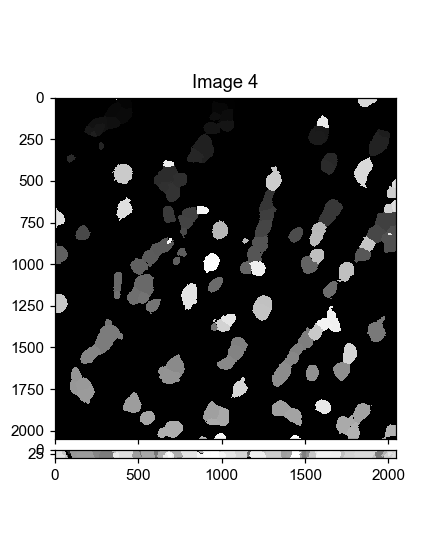

In [12]:
visual_tools.imshow_mark_3d_v2([_ref_cls.im_405, polyt_im, corr_labels3d, new_labels])